# 0. Importing Libraries

In [1]:
import torch, torchdata, torchtext
from torch import nn
import torch.nn.functional as F

import random, math, time
import datasets
import matplotlib.pyplot as plt
import torch.optim as optim

# Set device as GPU if available, else set to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

c:\Users\Jue\Desktop\A3\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


# 1. ETL: Loading dataset

In [2]:
import datasets

# Processed TALPCo dataset
corpus = datasets.load_dataset('minmarn/data_eng_myn_2')

In [3]:
corpus

DatasetDict({
    train: Dataset({
        features: ['eng', 'myn'],
        num_rows: 1097
    })
    test: Dataset({
        features: ['eng', 'myn'],
        num_rows: 138
    })
    validation: Dataset({
        features: ['eng', 'myn'],
        num_rows: 137
    })
})

## Extract language pair

In [4]:
SRC_LANGUAGE = 'eng' # English
TRG_LANGUAGE = 'myn' # Myanmar

In [5]:
corpus['train'][1][SRC_LANGUAGE]

'There are seven eggs in the refrigerator.'

In [6]:
corpus['train'][1][TRG_LANGUAGE]

'ရေခဲသေတ္တာထဲမှာ ကြက်ဥ ခုနစ်လုံး ရှိတယ်။'

# 2. Preprocessing

## Tokenization, Numericalization

In [7]:
# Place-holders
token_transform = {}
vocab_transform = {}

## Myanmar segmentation tool (myWord)

In [8]:
import math
import functools
import sys
import pickle

sys.setrecursionlimit(10**6)

# Myanmar syllable combination dictionaries (pretrained)
UNI_DICT_BIN = './app/data/unigram-word.bin'
BI_DICT_BIN = './app/data/bigram-word.bin'                

def read_dict(file_path):
    """Reads a binary dictionary file and returns its contents."""
    try:
        with open(file_path, 'rb') as file:
            return pickle.load(file)
    except FileNotFoundError:
        print(f"Dictionary file {file_path} not found!")
        return {}

class ProbDist(dict):
    """Probability distribution estimated from unigram/bigram data."""
    
    def __init__(self, datafile=None, unigram=True, total_count=102490):
        super().__init__()
        data = read_dict(datafile)
        self.update(data)
        self.total_count = total_count

        self.unknown_prob = (
            lambda word, N: 10 / (N * 10**len(word)) if unigram else lambda _, N: 1 / N
        )

    def __call__(self, key):
        """Returns the probability of a word, falling back on unknown probability estimation."""
        return self.get(key, 0) / self.total_count if key in self else self.unknown_prob(key, self.total_count)

# Load probability distributions
P_UNIGRAM = ProbDist(UNI_DICT_BIN, unigram=True)
P_BIGRAM = ProbDist(BI_DICT_BIN, unigram=False)

def conditional_prob(current_word, previous_word):
    """Computes conditional probability P(current_word | previous_word)."""
    bigram = f"{previous_word} {current_word}"
    return P_BIGRAM[bigram] / P_UNIGRAM[previous_word] if bigram in P_BIGRAM else P_UNIGRAM(current_word)

@functools.lru_cache(maxsize=2**10)
def viterbi(text, previous_word="<S>", max_length=20):
    """Viterbi algorithm for word segmentation based on maximum probability."""
    if not text:
        return 0.0, []

    max_length = min(len(text), max_length)
    splits = [(text[:i + 1], text[i + 1:]) for i in range(max_length)]

    candidates = [
        (
            math.log10(conditional_prob(first_word, previous_word)) + remain_prob,
            [first_word] + remain_words
        )
        for first_word, remaining_text in splits
        for remain_prob, remain_words in [viterbi(remaining_text, first_word)]
    ]

    return max(candidates, key=lambda x: x[0])


In [9]:
def my_tokenizer(text):
    """Myanmar tokenizer using Viterbi segmentation."""
    if not text:
        return []  # Handle None or empty input gracefully

    word_delimiter = '|'  # Define the word delimiter
    processed_text = text.replace(" ", "").strip()  # Remove spaces before processing

    # Perform Viterbi segmentation
    _, segmented_words = viterbi(processed_text)

    # Join words with delimiter, clean up formatting, and split back into a list
    cleaned_text = word_delimiter.join(segmented_words).strip(word_delimiter)
    return cleaned_text.split(word_delimiter)


## Tokenizers

In [10]:
print("Torch Version:", torch.__version__)
print("TorchText Version:", torchtext.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)

Torch Version: 2.2.0+cu118
TorchText Version: 0.17.0+cpu
CUDA Available: True
CUDA Version: 11.8


In [11]:
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = my_tokenizer

## Special token indices

In [12]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

## Build vocab

In [13]:
def yield_tokens(data, language):
    if not data:  # Handle None or empty data gracefully
        return

    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        if isinstance(data_sample, list):
            yield token_transform[language](data_sample[language_index[language]])
        elif isinstance(data_sample, dict):
            yield token_transform[language](data_sample.get(language, ""))


In [14]:
from torchtext.vocab import build_vocab_from_iterator

# Build vocabularies for source and target languages
for lang in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[lang] = build_vocab_from_iterator(
        yield_tokens(corpus['train'], lang), 
        min_freq=2,  # Tokens appearing less than twice will be treated as UNK
        specials=special_symbols,
        special_first=True  # Insert special tokens at the beginning
    )

# Set the default index for unknown tokens (UNK)
for lang in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[lang].set_default_index(UNK_IDX)


In [15]:
import pickle

pickle.dump(vocab_transform, open('./app/data/vocab.pkl', 'wb'))

In [16]:
vocab_transform = pickle.load(open('./app/data/vocab.pkl', 'rb'))

## Batching

In [17]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 16  # GPU memory limitation

# Helper function to apply sequential transformations
def sequential_transforms(*transforms):
    """Applies a sequence of transformations to the input text."""
    def func(txt_input):
        if not txt_input:  # Handle None or empty input
            return []
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# Function to add BOS/EOS and convert to tensor
def tensor_transform(token_ids):
    """Adds BOS (start-of-sequence) and EOS (end-of-sequence) tokens and converts to tensor."""
    return torch.cat((
        torch.tensor([SOS_IDX], dtype=torch.int64),
        torch.tensor(token_ids, dtype=torch.int64),
        torch.tensor([EOS_IDX], dtype=torch.int64)
    ))

# Define text transformations for source and target languages
text_transform = {
    lang: sequential_transforms(
        token_transform[lang],  # Tokenization
        vocab_transform[lang],  # Numericalization
        tensor_transform        # Add BOS/EOS and create tensor
    )
    for lang in [SRC_LANGUAGE, TRG_LANGUAGE]
}

# Collate function for batching data
def collate_batch(batch):
    """Collates data samples into padded batches with lengths."""
    src_batch, src_len_batch, trg_batch = [], [], []

    for lang_data in batch:
        for lang, tokens in lang_data.items():
            # Convert tokens to tensor, handling None or empty input safely
            processed_text = text_transform[lang](tokens) if tokens else torch.empty(0, dtype=torch.int64)
            
            if lang == SRC_LANGUAGE:
                src_batch.append(processed_text)
                src_len_batch.append(processed_text.size(0))
            elif lang == TRG_LANGUAGE:
                trg_batch.append(processed_text)

    # Pad source and target sequences
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True) if src_batch else torch.empty(0)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True) if trg_batch else torch.empty(0)

    # Adjust empty sequences to maximum length in the batch
    max_len = src_batch.size(1) if src_batch.numel() > 0 else 0
    src_len_batch = [length if length > 0 else max_len for length in src_len_batch]

    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch


In [18]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = BATCH_SIZE

# Create DataLoaders for train, validation, and test sets
train_loader = DataLoader(
    corpus['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch
)
valid_loader = DataLoader(
    corpus['validation'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch
)
test_loader = DataLoader(
    corpus['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch
)

# Alternative (if using a different test corpus)
# train_loader = DataLoader(corpus_test, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)


In [19]:
for eng, _, myn in train_loader:
    break

In [20]:
print("English shape: ", eng.shape)  # (seq len, batch_size)
print("Myanmar shape: ", myn.shape)   # (seq len, batch_size)

English shape:  torch.Size([16, 15])
Myanmar shape:  torch.Size([16, 19])


# 3. Model

## Encoder

### Encoder layer

In [21]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, mech):
        super().__init__()

        # Layer Normalization
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        # Attention and Feedforward Layers
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, mech)
        self.feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        # Self-Attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(_src))  # Residual Connection & Layer Norm

        # Feedforward Layer
        _src = self.feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(_src))  # Residual Connection & Layer Norm

        return src


### Encoder

In [22]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, 
                 mech, max_length=1000):
        super().__init__()

        self.device = device

        # Embedding layers
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        # Encoder layers
        self.layers = nn.ModuleList([
            EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device, mech)
            for _ in range(n_layers)
        ])

        # Dropout and scaling
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor(hid_dim, dtype=torch.float32, device=device))

    def forward(self, src, src_mask):
        batch_size, src_len = src.shape

        # Create positional encodings
        pos = torch.arange(src_len, device=self.device).unsqueeze(0).expand(batch_size, -1)

        # Apply token and positional embeddings
        src = self.dropout(self.tok_embedding(src) * self.scale + self.pos_embedding(pos))

        # Pass through encoder layers
        for layer in self.layers:
            src = layer(src, src_mask)

        return src


## Multihead Attention layer

In [23]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device, mech):
        super().__init__()

        assert hid_dim % n_heads == 0, "hid_dim must be divisible by n_heads"

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        self.mech = mech  # Attention mechanism type

        # Linear projections for Query, Key, and Value
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        # Additional layers for additive attention
        self.v = nn.Linear(self.head_dim, 1)
        self.W = nn.Linear(self.head_dim, self.head_dim)  # Used in multiplicative attention
        self.U = nn.Linear(self.head_dim, self.head_dim)

        # Final output projection
        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32, device=device))

    def forward(self, query, key, value, mask=None):
        batch_size, query_len, _ = query.shape
        key_len = key.shape[1]

        # Apply linear projections
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Reshape into multiple heads
        Q = Q.view(batch_size, query_len, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, key_len, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, key_len, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # Shape: [batch_size, n_heads, seq_len, head_dim]

        # Compute attention scores based on selected mechanism
        if self.mech == 'gen':  # General attention
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        elif self.mech == 'mul':  # Multiplicative attention
            energy = torch.matmul(Q, self.W(K).permute(0, 1, 3, 2)) / self.scale
        elif self.mech == 'add':  # Additive attention
            # Reshape Q and K for element-wise addition
            Q = Q.unsqueeze(3)  # [batch_size, n_heads, query_len, 1, head_dim]
            K = K.unsqueeze(2)  # [batch_size, n_heads, 1, key_len, head_dim]

            # Compute energy using additive attention formula
            energy = self.v(torch.tanh(self.W(Q) + self.U(K))) / self.scale
            energy = energy.squeeze(-1)  # Remove last dimension to match [batch_size, n_heads, query_len, key_len]

        # Apply mask if provided (e.g., padding mask)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        # Compute attention weights
        attention = torch.softmax(energy, dim=-1)

        # Apply attention to values
        x = torch.matmul(self.dropout(attention), V)

        # Reshape back to original size
        x = x.permute(0, 2, 1, 3).contiguous()  # [batch_size, query_len, n_heads, head_dim]
        x = x.view(batch_size, query_len, self.hid_dim)  # Merge heads

        # Final linear projection
        x = self.fc_o(x)

        return x, attention


## Decoder

### Decoder layer

In [24]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device, mech):
        super().__init__()

        assert hid_dim % n_heads == 0, "hid_dim must be divisible by n_heads"

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        self.mech = mech  # Attention mechanism type

        # Linear projections for Query, Key, and Value
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        # Additional layers for additive attention
        self.v = nn.Linear(self.head_dim, 1)
        self.W = nn.Linear(self.head_dim, self.head_dim)  # Used in multiplicative attention
        self.U = nn.Linear(self.head_dim, self.head_dim)

        # Final output projection
        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask=None):
        batch_size, query_len, _ = query.shape
        key_len = key.shape[1]

        # Apply linear projections
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Reshape into multiple heads
        Q = Q.view(batch_size, query_len, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, key_len, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, key_len, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # Shape: [batch_size, n_heads, seq_len, head_dim]

        # Compute attention scores based on selected mechanism
        if self.mech == 'gen':  # General attention
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        elif self.mech == 'mul':  # Multiplicative attention
            energy = torch.matmul(Q, self.W(K).permute(0, 1, 3, 2)) / self.scale
        elif self.mech == 'add':  # Additive attention
            # Reshape Q and K for element-wise addition
            Q = Q.unsqueeze(3)  # [batch_size, n_heads, query_len, 1, head_dim]
            K = K.unsqueeze(2)  # [batch_size, n_heads, 1, key_len, head_dim]

            # Compute energy using additive attention formula
            energy = self.v(torch.tanh(self.W(Q) + self.U(K))) / self.scale
            energy = energy.squeeze(-1)  # Remove last dimension to match [batch_size, n_heads, query_len, key_len]

        # Apply mask if provided (e.g., padding mask)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        # Compute attention weights
        attention = torch.softmax(energy, dim=-1)

        # Apply attention to values
        x = torch.matmul(self.dropout(attention), V)

        # Reshape back to original size
        x = x.permute(0, 2, 1, 3).contiguous()  # [batch_size, query_len, n_heads, head_dim]
        x = x.view(batch_size, query_len, self.hid_dim)  # Merge heads

        # Final linear projection
        x = self.fc_o(x)

        return x, attention


In [25]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, mech):
        super().__init__()

        # Layer Normalization
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        # Multi-Head Attention Layers
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, mech)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, mech)

        # Feedforward Layer
        self.feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)

        # Dropout Layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        # Self-Attention (Masked)
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))  # Residual Connection + Layer Norm

        # Encoder-Decoder Attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))  # Residual Connection + Layer Norm

        # Feedforward Network
        _trg = self.feedforward(trg)
        trg = self.ff_layer_norm(trg + self.dropout(_trg))  # Residual Connection + Layer Norm

        return trg, attention


### Decoder

In [26]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device, mech, max_length=1000):
        super().__init__()

        self.device = device
        self.mech = mech

        # Embedding layers
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        # Decoder layers
        self.layers = nn.ModuleList([
            DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device, mech)
            for _ in range(n_layers)
        ])

        # Final output layer
        self.fc_out = nn.Linear(hid_dim, output_dim)

        # Dropout and scaling
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        batch_size, trg_len = trg.shape

        # Create positional encodings
        pos = torch.arange(0, trg_len, device=self.device).unsqueeze(0).repeat(batch_size, 1)

        # Apply token and positional embeddings
        trg = self.dropout(self.tok_embedding(trg) * self.scale + self.pos_embedding(pos))

        # Pass through decoder layers
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # Compute final output
        output = self.fc_out(trg)

        return output, attention


### Positional Feedforward layer

In [27]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.dropout(self.activation(self.fc1(x))))


## Seq2Seq

In [28]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        return (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

    def make_trg_mask(self, trg):
        batch_size, trg_len = trg.shape

        # Padding mask: Ignore padded tokens
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # Look-ahead mask: Prevent attending to future tokens
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()

        # Combine both masks
        return trg_pad_mask & trg_sub_mask

    def forward(self, src, trg):
        # Create masks
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # Encode the source sequence
        enc_src = self.encoder(src, src_mask)

        # Decode the target sequence using the encoded source
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        return output, attention


# 4. Training

### Initialize functions

In [29]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight)


In [30]:
def initialize_model(attention_mech):
    # Define model hyperparameters
    INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
    OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
    HID_DIM = 256
    ENC_LAYERS = 3
    DEC_LAYERS = 3
    ENC_HEADS = 8
    DEC_HEADS = 8
    ENC_PF_DIM = 512
    DEC_PF_DIM = 512
    ENC_DROPOUT = 0.1
    DEC_DROPOUT = 0.1

    # Initialize Encoder and Decoder
    encoder = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device, attention_mech)
    decoder = Decoder(OUTPUT_DIM, HID_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device, attention_mech)

    # Define padding index
    SRC_PAD_IDX = PAD_IDX
    TRG_PAD_IDX = PAD_IDX

    # Create Transformer model
    model = Seq2SeqTransformer(encoder, decoder, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

    # Apply weight initialization
    model.apply(initialize_weights)

    return model


In [31]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total Trainable Parameters: {total_params:,}")

    return total_params


## General Attention model

In [32]:
genmodel = initialize_model('gen')

In [33]:
count_parameters(genmodel)

Total Trainable Parameters: 4,999,389


4999389

## Multiplicative Attention model

In [34]:
mulmodel = initialize_model('mul')

In [35]:
#we can print the complexity by the number of parameters   
count_parameters(mulmodel)

Total Trainable Parameters: 4,999,389


4999389

## Additive Attention model

In [36]:
addmodel = initialize_model('add')

In [37]:
#we can print the complexity by the number of parameters   
count_parameters(addmodel)

Total Trainable Parameters: 4,999,389


4999389

## Optimizer and learning rate

In [38]:
import torch.optim as optim
import torch.nn as nn

# Define learning rate
lr = 0.001

# Training hyperparameters
def initialize_optimizer_and_loss(model):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)  # Ignores padding index in loss calculation

    return optimizer, criterion

# Initialize for different models
optimizer_gen, criterion_gen = initialize_optimizer_and_loss(genmodel)
optimizer_mul, criterion_mul = initialize_optimizer_and_loss(mulmodel)
optimizer_add, criterion_add = initialize_optimizer_and_loss(addmodel)


## Train/ Evaluate functions

In [39]:
import torch

def train(model, loader, optimizer, criterion, clip, loader_length):
    model.train()
    epoch_loss = 0

    for src, src_len, trg in loader:
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()

        # Remove <EOS> from target input (for teacher forcing)
        output, _ = model(src, trg[:, :-1])

        # Reshape output and target for loss computation
        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)  # [batch_size * (trg_len - 1), output_dim]
        trg = trg[:, 1:].reshape(-1)  # Remove <SOS> from target

        # Compute loss
        loss = criterion(output, trg)

        # Backpropagation and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  # Gradient clipping
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length


In [40]:
import torch

def evaluate(model, loader, criterion, loader_length):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for src, src_len, trg in loader:
            src, trg = src.to(device), trg.to(device)

            # Remove <EOS> from target input
            output, _ = model(src, trg[:, :-1])

            # Reshape output and target for loss computation
            output_dim = output.shape[-1]
            output = output.view(-1, output_dim)  # [batch_size * (trg_len - 1), output_dim]
            trg = trg[:, 1:].reshape(-1)  # Remove <SOS> from target

            # Compute loss
            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / loader_length


In [41]:
train_loader_length = len(train_loader)
val_loader_length = len(valid_loader)
test_loader_length = len(test_loader)

In [42]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = elapsed_time // 60  # Floor division for integer minutes
    elapsed_secs = int(elapsed_time % 60)  # Modulus for remaining seconds

    return int(elapsed_mins), elapsed_secs


In [43]:
import time
import torch
import math

def train_loop(model, optimizer, criterion, num_epochs=10, clip=1):
    best_valid_loss = float('inf')
    best_train_loss = 0

    # Define model save path
    save_path = f'./app/models/{model.decoder.mech}model.pt'

    # Store training and validation losses
    train_losses, valid_losses = [], []

    total_start = time.time()  # Track total training time

    for epoch in range(num_epochs):
        start_time = time.time()

        # Train and evaluate
        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

        # Store losses for plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Save best model (based on validation loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_train_loss = train_loss
            torch.save(model.state_dict(), save_path)

        # Print epoch summary
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    # Final training time
    total_end = time.time()
    total_min, total_sec = epoch_time(total_start, total_end)
    print(f'Total Training Time: {total_min}m {total_sec}s')

    return train_losses, valid_losses, best_valid_loss, best_train_loss


In [44]:
def test_loop(model):
    # Load the best saved model
    save_path = f'./app/models/{model.decoder.mech}model.pt'
    model.load_state_dict(torch.load(save_path))

    # Evaluate on the test dataset
    test_loss = evaluate(model, test_loader, criterion_gen, test_loader_length)

    # Print test results
    print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

    return test_loss


### Result function

In [45]:
import math

def result_print(train_loss, valid_loss):
    print(f"Training Loss   : {train_loss:.3f} | Perplexity: {math.exp(train_loss):7.3f}")
    print(f"Validation Loss : {valid_loss:.3f} | Perplexity: {math.exp(valid_loss):7.3f}")


### Plot function

In [46]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, valid_losses):
    plt.figure(figsize=(6, 4))
    
    plt.plot(train_losses, label='Training Loss', marker='o', linestyle='-')
    plt.plot(valid_losses, label='Validation Loss', marker='s', linestyle='--')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)
    
    plt.show()


## General train

Epoch: 01 | Time: 0m 15s
	Train Loss: 4.722 | Train PPL: 112.389
	 Val. Loss: 4.214 |  Val. PPL:  67.639
Epoch: 02 | Time: 0m 14s
	Train Loss: 4.017 | Train PPL:  55.547
	 Val. Loss: 3.823 |  Val. PPL:  45.761
Epoch: 03 | Time: 0m 14s
	Train Loss: 3.648 | Train PPL:  38.380
	 Val. Loss: 3.640 |  Val. PPL:  38.083
Epoch: 04 | Time: 0m 14s
	Train Loss: 3.346 | Train PPL:  28.386
	 Val. Loss: 3.509 |  Val. PPL:  33.421
Epoch: 05 | Time: 0m 13s
	Train Loss: 3.110 | Train PPL:  22.417
	 Val. Loss: 3.394 |  Val. PPL:  29.788
Epoch: 06 | Time: 0m 14s
	Train Loss: 2.905 | Train PPL:  18.257
	 Val. Loss: 3.338 |  Val. PPL:  28.154
Epoch: 07 | Time: 0m 13s
	Train Loss: 2.717 | Train PPL:  15.135
	 Val. Loss: 3.268 |  Val. PPL:  26.252
Epoch: 08 | Time: 0m 14s
	Train Loss: 2.541 | Train PPL:  12.688
	 Val. Loss: 3.216 |  Val. PPL:  24.937
Epoch: 09 | Time: 0m 13s
	Train Loss: 2.400 | Train PPL:  11.027
	 Val. Loss: 3.240 |  Val. PPL:  25.545
Epoch: 10 | Time: 0m 14s
	Train Loss: 2.251 | Train PPL

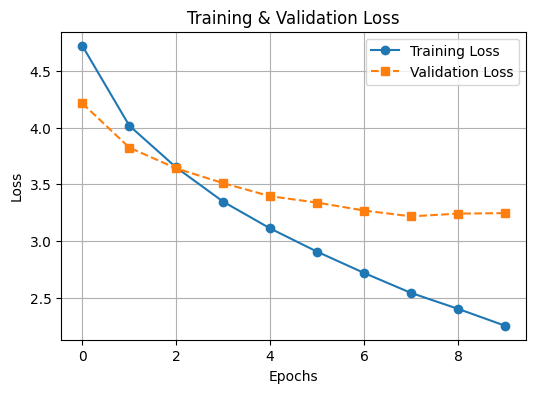

In [47]:
# Train the model and store losses
train_losses, valid_losses, gen_val_loss, gen_train_loss = train_loop(genmodel, optimizer_gen, criterion_gen)

# Print final training results
result_print(gen_train_loss, gen_val_loss)

# Plot loss curves
plot_loss(train_losses, valid_losses)


In [48]:
result_print(gen_train_loss, gen_val_loss)

Training Loss   : 2.541 | Perplexity:  12.688
Validation Loss : 3.216 | Perplexity:  24.937


In [49]:
test_loop(genmodel)

| Test Loss: 3.283 | Test PPL:  26.664 |


3.2833265198601618

## Multiplicative train

Epoch: 01 | Time: 0m 14s
	Train Loss: 4.574 | Train PPL:  96.940
	 Val. Loss: 4.055 |  Val. PPL:  57.702
Epoch: 02 | Time: 0m 14s
	Train Loss: 3.796 | Train PPL:  44.509
	 Val. Loss: 3.673 |  Val. PPL:  39.364
Epoch: 03 | Time: 0m 14s
	Train Loss: 3.393 | Train PPL:  29.760
	 Val. Loss: 3.493 |  Val. PPL:  32.884
Epoch: 04 | Time: 0m 15s
	Train Loss: 3.091 | Train PPL:  22.009
	 Val. Loss: 3.297 |  Val. PPL:  27.036
Epoch: 05 | Time: 0m 14s
	Train Loss: 2.817 | Train PPL:  16.729
	 Val. Loss: 3.149 |  Val. PPL:  23.321
Epoch: 06 | Time: 0m 14s
	Train Loss: 2.585 | Train PPL:  13.264
	 Val. Loss: 3.130 |  Val. PPL:  22.881
Epoch: 07 | Time: 0m 14s
	Train Loss: 2.355 | Train PPL:  10.534
	 Val. Loss: 3.149 |  Val. PPL:  23.322
Epoch: 08 | Time: 0m 14s
	Train Loss: 2.169 | Train PPL:   8.750
	 Val. Loss: 3.068 |  Val. PPL:  21.490
Epoch: 09 | Time: 0m 14s
	Train Loss: 1.980 | Train PPL:   7.242
	 Val. Loss: 3.116 |  Val. PPL:  22.549
Epoch: 10 | Time: 0m 14s
	Train Loss: 1.813 | Train PPL

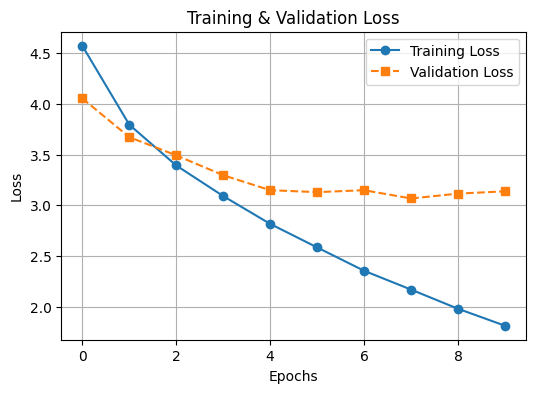

In [50]:
# Train the multiplicative attention model
train_losses, valid_losses, mul_train_loss, mul_val_loss = train_loop(mulmodel, optimizer_mul, criterion_mul)

# Print final training results
result_print(mul_train_loss, mul_val_loss)

# Plot loss curves
plot_loss(train_losses, valid_losses)


In [51]:
result_print(mul_train_loss, mul_val_loss)

Training Loss   : 3.068 | Perplexity:  21.490
Validation Loss : 2.169 | Perplexity:   8.750


In [52]:
test_loop(mulmodel)

| Test Loss: 3.119 | Test PPL:  22.628 |


3.1191855006747775

## Additive train

Epoch: 01 | Time: 0m 17s
	Train Loss: 4.589 | Train PPL:  98.430
	 Val. Loss: 3.946 |  Val. PPL:  51.749
Epoch: 02 | Time: 0m 14s
	Train Loss: 3.636 | Train PPL:  37.955
	 Val. Loss: 3.453 |  Val. PPL:  31.610
Epoch: 03 | Time: 0m 15s
	Train Loss: 3.068 | Train PPL:  21.500
	 Val. Loss: 3.259 |  Val. PPL:  26.012
Epoch: 04 | Time: 0m 15s
	Train Loss: 2.667 | Train PPL:  14.393
	 Val. Loss: 3.104 |  Val. PPL:  22.291
Epoch: 05 | Time: 0m 15s
	Train Loss: 2.363 | Train PPL:  10.623
	 Val. Loss: 3.027 |  Val. PPL:  20.636
Epoch: 06 | Time: 0m 15s
	Train Loss: 2.101 | Train PPL:   8.174
	 Val. Loss: 3.055 |  Val. PPL:  21.232
Epoch: 07 | Time: 0m 15s
	Train Loss: 1.892 | Train PPL:   6.630
	 Val. Loss: 3.103 |  Val. PPL:  22.274
Epoch: 08 | Time: 0m 15s
	Train Loss: 1.681 | Train PPL:   5.369
	 Val. Loss: 3.085 |  Val. PPL:  21.857
Epoch: 09 | Time: 0m 15s
	Train Loss: 1.522 | Train PPL:   4.584
	 Val. Loss: 3.172 |  Val. PPL:  23.844
Epoch: 10 | Time: 0m 14s
	Train Loss: 1.374 | Train PPL

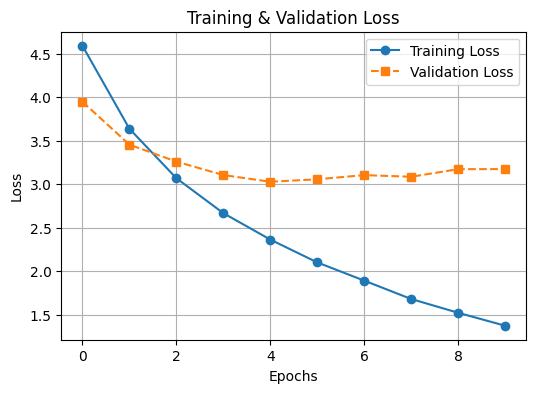

In [53]:
# Train the additive attention model
train_losses, valid_losses, add_train_loss, add_val_loss = train_loop(addmodel, optimizer_add, criterion_add)

# Print final training results
result_print(add_train_loss, add_val_loss)

# Plot loss curves
plot_loss(train_losses, valid_losses)


In [54]:
result_print(add_train_loss, add_val_loss)

Training Loss   : 3.027 | Perplexity:  20.636
Validation Loss : 2.363 | Perplexity:  10.623


In [55]:
test_loop(addmodel)

| Test Loss: 3.071 | Test PPL:  21.559 |


3.0707893636491566

# 5. Inference

## Generator function

In [56]:
# Retrieve index-to-token mappings for source and target languages
mapping = {
    SRC_LANGUAGE: vocab_transform[SRC_LANGUAGE].get_itos(),
    TRG_LANGUAGE: vocab_transform[TRG_LANGUAGE].get_itos()
}


In [57]:
def greedy_decode(model, src, max_len=50, device=device):
    # Convert source sentence to tensor
    src_tensor = text_transform[SRC_LANGUAGE](src).to(device).unsqueeze(0)  # Tokenize & convert to tensor
    model.eval()

    trg_indexes = [SOS_IDX]  # Start with <sos>

    for _ in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        with torch.no_grad():
            output, attentions = model(src_tensor, trg_tensor)  # Get model prediction
        
        pred_token = output.argmax(dim=2)[:, -1].item()  # Get highest probability token
        trg_indexes.append(pred_token)

        if pred_token == EOS_IDX:  # Stop if <eos> is generated
            break

    # Convert token IDs to words
    trg_tokens = [mapping[TRG_LANGUAGE][idx] for idx in trg_indexes]

    return trg_tokens[1:], attentions  # Exclude <sos> token


## General inference

In [ ]:
# Define model save path
save_path = './app/models/genmodel.pt'

# Load the trained model
try:
    genmodel.load_state_dict(torch.load(save_path, map_location=device))
    print("Model loaded successfully.")
except FileNotFoundError:
    print(f"Error: Model file not found at {save_path}")
except Exception as e:
    print(f"Error loading model: {e}")


Model loaded successfully.


In [59]:
# Example usage of greedy decoding
gen_src_sentence = "I go to school"

try:
    # Perform greedy decoding
    gen_output_sentence, gen_attentions = greedy_decode(genmodel, gen_src_sentence, max_len=50, device=device)

    # Print the generated sentence
    print("Predicted Sentence:", ' '.join(gen_output_sentence))
except Exception as e:
    print(f"Error during decoding: {e}")


Predicted Sentence: မ နေ့ က ကျောင်း သွား တယ် ။ <eos>


## Multiplicative inference

In [ ]:
# Define model save path
save_path = './app/models/mulmodel.pt'

# Load the trained model with error handling
try:
    mulmodel.load_state_dict(torch.load(save_path, map_location=device))
    print("Multiplicative Attention Model loaded successfully.")
except FileNotFoundError:
    print(f"Error: Model file not found at {save_path}")
except Exception as e:
    print(f"Error loading model: {e}")


Multiplicative Attention Model loaded successfully.


In [61]:
# Example usage of greedy decoding with multiplicative attention model
mul_src_sentence = "I go to eat rice"

try:
    # Perform greedy decoding
    mul_output_sentence, mul_attentions = greedy_decode(mulmodel, mul_src_sentence, max_len=50, device=device)

    # Print the generated sentence
    print("Predicted Sentence:", ' '.join(mul_output_sentence))
except Exception as e:
    print(f"Error during decoding: {e}")


Predicted Sentence: ကျွန်တော် မနက် တိုင်း ကော်ဖီ ဆိုင် မှာ တင်းနစ် ရိုက် တယ် ။ <eos>


## Additive inference

In [62]:
import torch

# Define model save path
save_path = './app/models/addmodel.pt'

# Load the trained model with error handling
try:
    addmodel.load_state_dict(torch.load(save_path, map_location=device))
    print("Additive Attention Model loaded successfully.")
except FileNotFoundError:
    print(f"Error: Model file not found at {save_path}")
except Exception as e:
    print(f"Error loading model: {e}")


Additive Attention Model loaded successfully.


In [64]:
# Example usage of greedy decoding with additive attention model
add_src_sentence = "I eat bread"

try:
    # Perform greedy decoding
    add_output_sentence, add_attentions = greedy_decode(addmodel, add_src_sentence, max_len=50, device=device)

    # Print the generated sentence
    print("Predicted Sentence:", ' '.join(add_output_sentence))
except Exception as e:
    print(f"Error during decoding: {e}")


Predicted Sentence: ကျွန်တော် ပေါင်မုန့် စား တယ် ။ <eos>


## Attention map

## Random sample for attention map

In [66]:
# Extract source and target text from the first training sample
try:
    src_text = corpus['train'][0]['eng']  # Source sentence in English
    trg_text = corpus['train'][0]['myn']  # Target sentence in Myanmar
    print(f"Source: {src_text}\nTarget: {trg_text}")
except (KeyError, IndexError) as e:
    print(f"Error extracting text: {e}")


Source: What kind of food is it?
Target: အဲဒါ ဘယ်လိုအစားအစာမျိုးလဲ။


In [67]:
# Convert source and target text into tensors
try:
    source = text_transform[SRC_LANGUAGE](src_text).to(device).unsqueeze(0)  # Tokenize & convert to tensor
    target = text_transform[TRG_LANGUAGE](trg_text).to(device).unsqueeze(0)  # Tokenize & convert to tensor

    print(f"Source Tensor: {source.shape}")  # Debugging
    print(f"Target Tensor: {target.shape}")
except Exception as e:
    print(f"Error during text transformation: {e}")


Source Tensor: torch.Size([1, 9])
Target Tensor: torch.Size([1, 8])


In [ ]:
# Perform inference with no gradient computation
def generate_output(model, source, target, model_name="Model"):
    try:
        with torch.no_grad():
            output, attentions = model(source, target)
        print(f"{model_name} inference completed successfully.")
        return output, attentions
    except Exception as e:
        print(f"Error during {model_name} inference: {e}")
        return None, None

# Run inference on all models
gen_output, gen_attentions = generate_output(genmodel, source, target, model_name="GenModel")
mul_output, mul_attentions = generate_output(mulmodel, source, target, model_name="MulModel")
add_output, add_attentions = generate_output(addmodel, source, target, model_name="AddModel")


GenModel inference completed successfully.
MulModel inference completed successfully.
AddModel inference completed successfully.


In [69]:
def get_output(output):
    try:
        output = output.squeeze(0)  # Remove batch dimension -> [trg_len, vocab_size]
        output_max = output[1:].argmax(dim=1)  # Get highest probability token for each timestep

        # Convert token indices to words
        trg_tokens = ['<sos>'] + [mapping[TRG_LANGUAGE][token.item()] for token in output_max]
        
        return trg_tokens
    except Exception as e:
        print(f"Error during output decoding: {e}")
        return []


In [70]:
def tokenize_source(src_text):
    try:
        src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](src_text) + ['<eos>']
        return src_tokens
    except Exception as e:
        print(f"Error during source tokenization: {e}")
        return []
    
# Example usage
src_tokens = tokenize_source(src_text)
print("Tokenized Source:", src_tokens)


Tokenized Source: ['<sos>', 'What', 'kind', 'of', 'food', 'is', 'it', '?', '<eos>']


### Attention function

In [71]:
import warnings

def suppress_warnings(category=UserWarning):
    warnings.filterwarnings("ignore", category=category)
    
# Suppress UserWarnings (default)
suppress_warnings()


In [72]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def display_attention(sentence, translation, attention):
    try:
        fig, ax = plt.subplots(figsize=(10, 10))

        # Extract first attention head
        attention = attention[0, 0, :, :].squeeze(1).cpu().detach().numpy()

        # Display attention heatmap
        cax = ax.matshow(attention, cmap='bone')

        # Set tick parameters
        ax.tick_params(labelsize=10)

        # Set axis labels with tokens
        ax.set_xticks(range(len(sentence)))
        ax.set_xticklabels(sentence, rotation=45, ha="left")

        ax.set_yticks(range(len(translation)))
        ax.set_yticklabels(translation, fontname='Myanmar Text')

        # Adjust tick spacing
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        # Show the plot
        plt.colorbar(cax)
        plt.show()
        plt.close()

    except Exception as e:
        print(f"Error displaying attention: {e}")


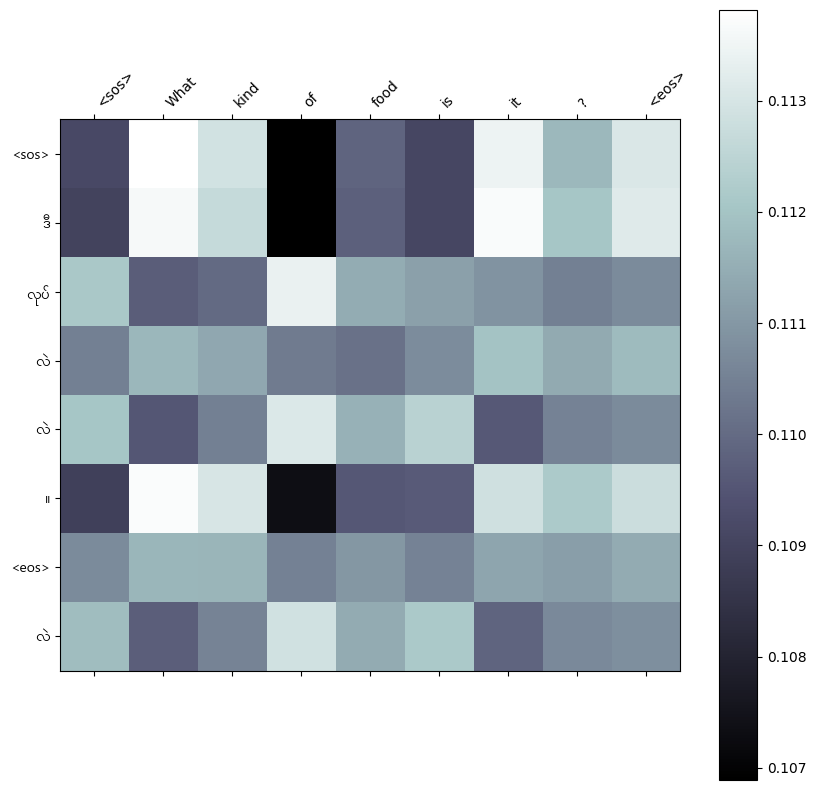

Generated Translation: <sos> ဒီ လုပ် လဲ လဲ ။ <eos> လဲ


In [73]:
try:
    # Extract predicted target tokens
    trg_tokens = get_output(gen_output)

    # Display attention visualization
    display_attention(src_tokens, trg_tokens, gen_attentions)

    # Print the generated translation
    print("Generated Translation:", ' '.join(trg_tokens))
except Exception as e:
    print(f"Error during translation display: {e}")


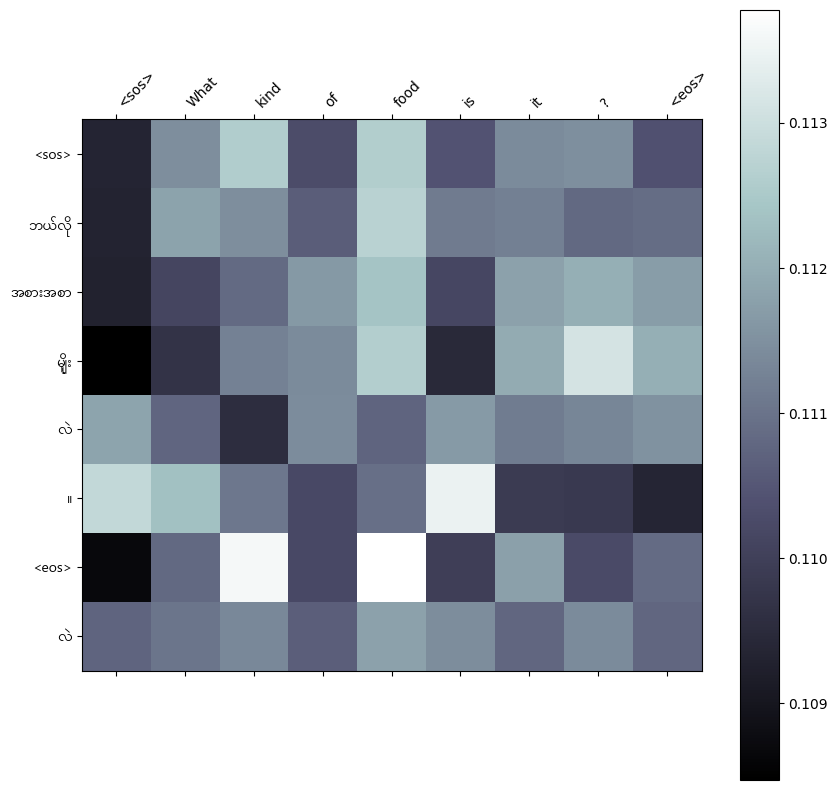

Generated Translation: <sos> ဘယ်လို အစားအစာ မျိုး လဲ ။ <eos> လဲ


In [74]:
try:
    # Extract predicted target tokens
    trg_tokens = get_output(mul_output)

    # Display attention visualization
    display_attention(src_tokens, trg_tokens, mul_attentions)

    # Print the generated translation
    print("Generated Translation:", ' '.join(trg_tokens))
except Exception as e:
    print(f"Error during translation display: {e}")


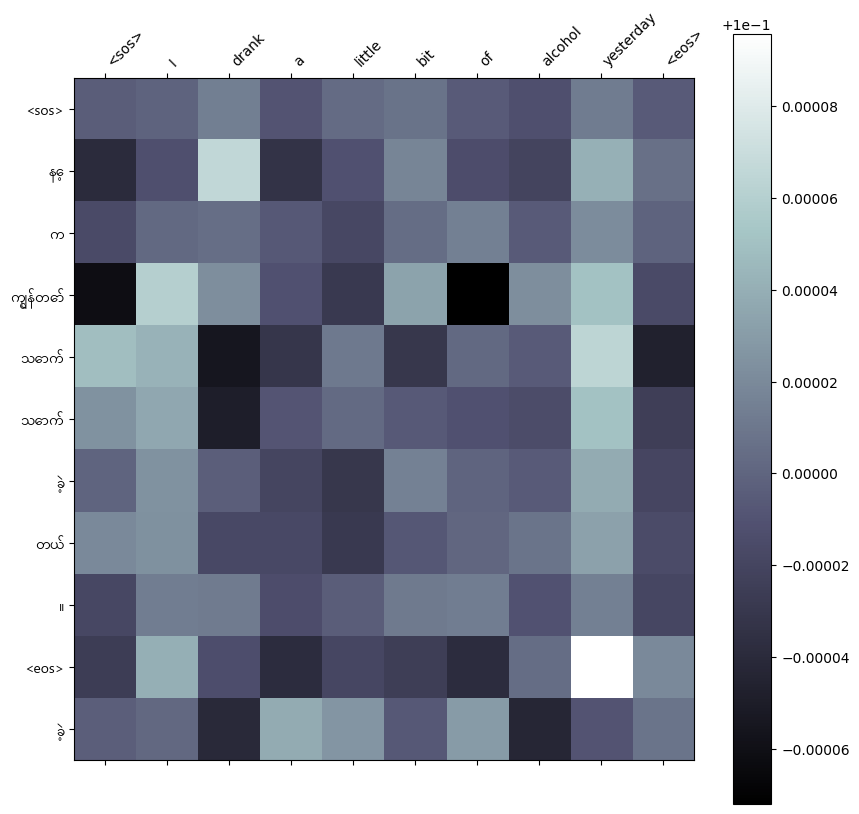

Generated Translation: <sos> နေ့ က ကျွန်တော် သောက် သောက် ခဲ့ တယ် ။ <eos> ခဲ့


In [77]:
try:
    # Extract predicted target tokens
    trg_tokens = get_output(add_output)

    # Display attention visualization
    display_attention(src_tokens, trg_tokens, add_attentions)

    # Print the generated translation
    print("Generated Translation:", ' '.join(trg_tokens))
except Exception as e:
    print(f"Error during translation display: {e}")


## BLEU score

In [79]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Select a sentence from the training corpus
src_text = corpus['train'][56]['eng']
trg_text = corpus['train'][56]['myn']

# Tokenize the reference translation
trg_token = token_transform[TRG_LANGUAGE](trg_text)

# Generate model output
gen_output, _ = greedy_decode(genmodel, src_text, max_len=50, device=device)

# Compute BLEU score with smoothing
smoothing = SmoothingFunction().method1  # Handles short sentences better
bleu_score = sentence_bleu([trg_token], gen_output, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing)

# Display results
print(f"Source: {src_text}")
print(f"Reference Translation: {' '.join(trg_token)}")
print(f"Generated Translation: {' '.join(gen_output)}")
print(f"BLEU Score: {bleu_score:.4f}")


Source: I eat while watching TV.
Reference Translation: တီဗွီ ကြည့် ရင်း ထမင်း စား တယ် ။
Generated Translation: ကျွန်တော် နေ့ တိုင်း ထမင်း စား တယ် ။ <eos>
BLEU Score: 0.4629
